## 50 - Satellite Data with CLASS Part 7

[Youtube](https://www.youtube.com/watch?v=1tMN_Ucbvqk)

[GOES Calibration - Conversion of GVAR Infrared Data to
Scene Radiance or Temperature](https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html)

[NOAA CLASS](https://www.avl.class.noaa.gov/saa/products/welcome)

Make sure: User preferences > GVAR Data Extraction Preferences > GVAR_IMG > NetCDF  &nbsp; (Metpy Monday #44)

How to download files &nbsp; (Metpy Monday #45) <br/>
Quick summary: <br/>

Search Data > Environmental Data from Geostationary Satellites > GOES Satellite Data - Imager (GVAR_IMG) <br/>
Set options:
- Start Date: 27 April 2011 19:00:00 
- End Date: 27 April 2011 20:59:59 
- Coverage: Continental United States
- Satellite Schedule: Routine, Rapid Scan Operation
- Satellite: GOES-13

... or ... <br/>

[File directory](https://download.avl.class.noaa.gov/download/8369075216/001)

file names: 
- goes13.2011.117.200229.BAND_01.nc
- goes13.2011.117.200229.BAND_02.nc
- goes13.2011.117.200229.BAND_03.nc
- goes13.2011.117.200229.BAND_04.nc
- goes13.2011.117.200229.BAND_06.nc

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [2]:
file_wv = 'satellite_data/goes13.2011.117.200229.BAND_03.nc'

In [3]:
ds_wv = Dataset(file_wv, 'r')

wv_10bit = ds_wv.variables['data'][0]/32

In [4]:
lat_wv = np.ma.masked_values(ds_wv.variables['lat'], 2.14329e+09)
lon_wv = np.ma.masked_values(ds_wv.variables['lon'], 2.14329e+09)

wv_masked = np.ma.masked_array(wv_10bit, mask = lat_wv.mask)

In [5]:
# Table 1-2. GOES-12 and -O Imager Scaling Coefficients - Channel 3
m_wv = 38.8383
b_wv = 29.1287

R_wv = (wv_masked - b_wv)/m_wv

# Inverse Planck Function constants
c1 = 1.191066e-05
c2 = 1.438833

# GOES 13 coefficients for channel 3
# Table 2-6. GOES-13 Imager (Side 1) Coefficients
# channel 3 detector a
n_wv = 1522.52

a_wv = -3.625663

b_wv = 1.010018

T_eff_wv = (c2 * n_wv)/(np.log(1 + (c1 * n_wv**3)/R_wv))

BT_wv = a_wv + b_wv * T_eff_wv
BT_wv.max()

/tmp/ipykernel_143244/1393789347.py:20: RuntimeWarning: invalid value encountered in log
  T_eff_wv = (c2 * n_wv)/(np.log(1 + (c1 * n_wv**3)/R_wv))


260.8463

In [6]:
mapcrs = ccrs.Geostationary(central_longitude = -75)

ilon_min = np.unravel_index(np.argmin(lon_wv), lon_wv.shape)
ilon_max = np.unravel_index(np.argmax(lon_wv), lon_wv.shape)

ilat_min = np.unravel_index(np.argmin(lat_wv), lat_wv.shape)
ilat_max = np.unravel_index(np.argmax(lat_wv), lat_wv.shape)

LONpt0 = mapcrs.transform_point(lon_wv[ilon_min], lat_wv[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_wv[ilon_max], lat_wv[ilon_max], ccrs.Geodetic())[0]

LATpt0 = mapcrs.transform_point(lon_wv[ilat_min], lat_wv[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_wv[ilat_max], lat_wv[ilat_max], ccrs.Geodetic())[1]

In [7]:
vtime = num2date(ds_wv.variables['time'][:], units = ds_wv.variables['time'].units)

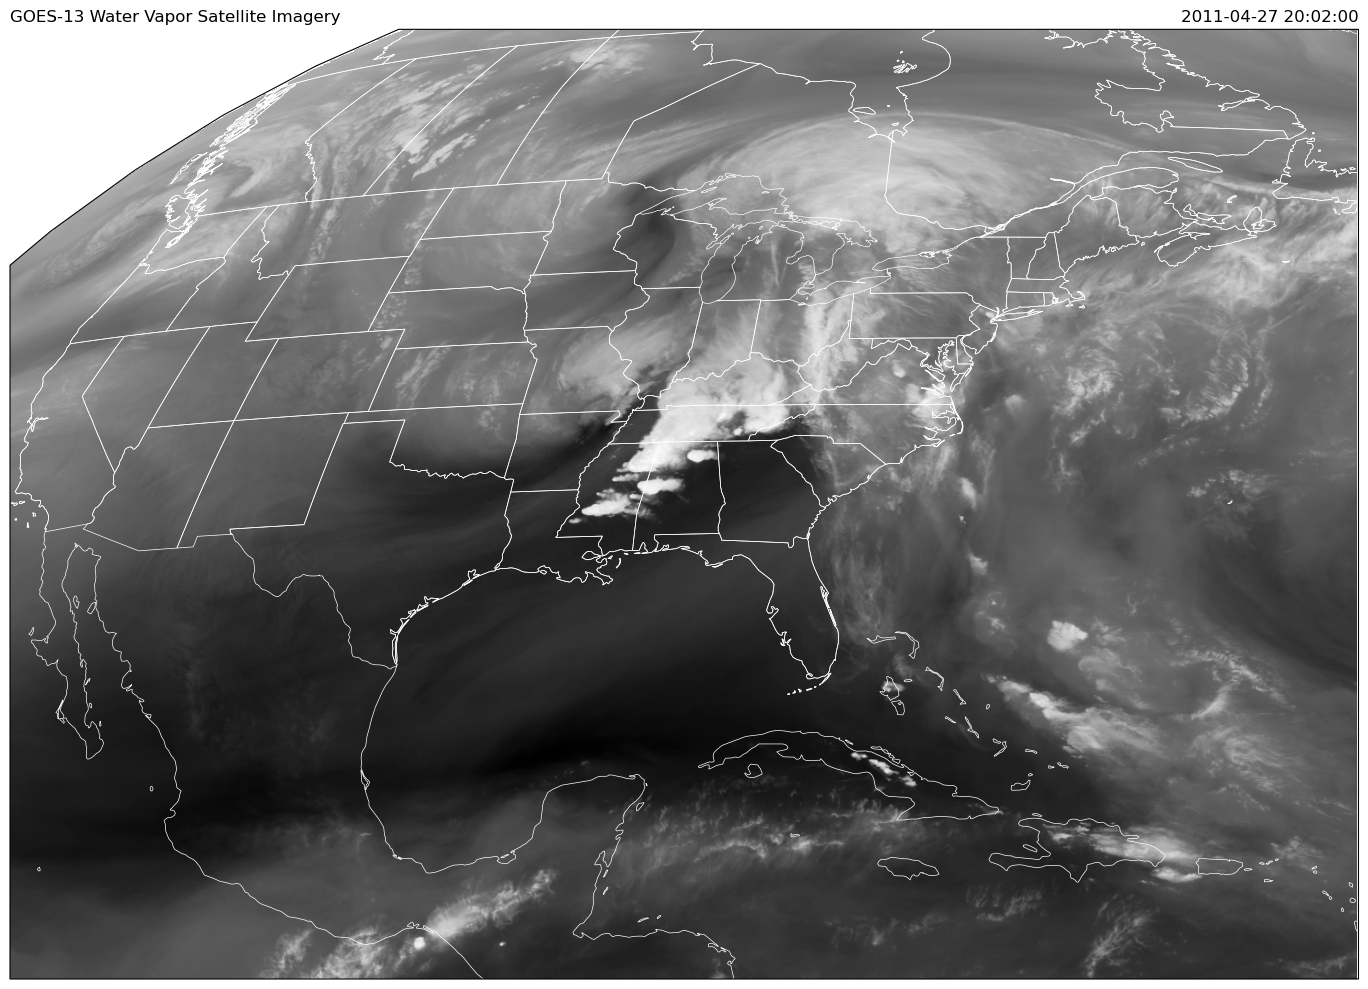

In [8]:
fig = plt.figure(1, figsize = (19, 10))
ax = plt.subplot(111, projection = mapcrs)
img = ax.imshow(BT_wv, cmap = 'Greys', origin = 'upper', extent = (LONpt0, LONpt1, LATpt0, LATpt1))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)

plt.title(vtime[0], loc = 'right')
plt.title('GOES-13 Water Vapor Satellite Imagery', loc = 'left')

plt.tight_layout()
plt.show()